## Closed-form estimation of message-update vector G

### The message-update coefficients G and latent state probabilities x form a system of linear equations, allowing G to be estimated in closed form when the number of latent state nodes is greater than or equal to the number of uknowns (i.e., elements of G) and the function operating on G to produce the latent state probabilities is invertible (i.e., the cols of the matrix are linearly independent). 

In [2]:
%pylab inline
import sys, importlib
sys.path.append('../code')
from notebookutils import *
# Also import modules using aliases so I can reload them when I make an edit
import notebookutils as ntutils
import tapdynamics as tap
import particlefilter as pfil
importlib.reload(ntutils)
importlib.reload(tap)
importlib.reload(pfil)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<module 'particlefilter' from '/its/home/cg610/coarse_graining_algorithms/coarse_graining_algorithms/notebooks/../code/particlefilter.py'>

## 1. Initialize parameters to true values

In [52]:
import numpy as np
# Do exact inference when data are constrained by number of nodes
# Ns = no. of latent variables, Ny = no. of inputs
Ns, Nr, Ny = 18,2,18

B_train = 1       # No. of batches; I changed from 25k to 2.5k for training batches. 
                                 # It's also kind of confusing because a single batch is Ns x T 
                                 # instead of multiple Ns x T
                                 # 
T = 30                         # No. of time steps 
kernel  = 30                     # Sliding window
stride = 5                       # how big each jump is
                                 # Here we have consistent input for the entire time period

##################
# These parameters are not used since observations are binary                                 
T_low, T_high = T, T+1           # range of time periods for which input is held constant: T and T+1 means constant for entire period
# T_low, T_high = 2, 5          # range of time periods for which input is held constant
yG_low, yG_high = np.sqrt(Ns), np.sqrt(Ns)   # These input gains give us binary observations
#yG_low, yG_high = 2, 3   # 

# process and observation noise covariance matrices
q_process, q_obs = 0, 0
Q_process, Q_obs = q_process*np.eye(Ns), q_obs*np.eye(Nr)    

# filter used for smoothing the input signals
# Carter changed from signal.hamming to signal.windows.hamming 
smoothing_filter = signal.windows.hamming(5,sym=True) 
smoothing_filter = smoothing_filter/sum(smoothing_filter)


# ground truth TAP model parameters
# lam controls how much new messages update activation
# lam = np.array([0.25])  # low pass filtering constant for the TAP dynamics
lam = np.array([1])  # low pass filtering constant for the TAP dynamics
# This should give us J*x_i*x_j
# The values of G are the coefficients G in the expression G_abc*J^a*x_i^b*x_j^c, where the index corresponds to
# the exponent of J, x_i, and x_j. I believe the order is 100, 101, 102, 110, 111... so the element at index 1 (101) means
# that a and c have exponent 1. In other words, message to Xi only depends on J*Xj
G_TAP   = np.array([0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]) # message passing parameters of the TAP equation
G_MF   = np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) # mean field parameters

# Connectivity matrix between state nodes
# Ns x Ns
self_coupling_on, sparsity_J, gain_J, Jtype  = 0, 0.5, 3, 'nonferr' # interaction matrix settings
J = gain_J*Create_J(Ns, sparsity_J, Jtype, self_coupling_on)
#J = array([[0,.8,-.4],[.8,0,.2],[-.4,.2,0]])  # No state dependence

# Connectivity matrix between state and observation nodes
# Ns x Ny
if Ns <= Ny:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]
# V = array([[-1,1,1],[1,-1,-1],[1,1,-1]])*3.5
V = np.zeros((Ns,Ny))  # No input dependence
# Empty embedding matrix because we don't care about neural response

embedding_arr = (Nr,Ns)
U = np.zeros(embedding_arr)
theta_TAP = np.concatenate([lam, G_TAP, JMatToVec(J), U.flatten('F'), V.flatten('F') ])
theta_MF = np.concatenate([lam, G_MF, JMatToVec(J), U.flatten('F'), V.flatten('F') ])

params = {'Ns':Ns,'Ny':Ny,'Nr':Nr,'Q_process':Q_process,'Q_obs':Q_obs,'nltype':'sigmoid','gain_y':25/np.sqrt(Ns),'smoothing_filter':smoothing_filter,'self_coupling_on':self_coupling_on,'sparsity_J':sparsity_J,'Jtype':Jtype  }

batches = 1
##################
# Specify sampling or message passing function
# runTAP - message passing
# runTAPSampling - sampling
TAP_func=runTAP
y_train_TAP, x_train_TAP, r_train_TAP = tap.generate_TAPdynamics(theta_TAP, params, batches, T, T_low, T_high, yG_low, yG_high,kernel,stride,TAP_func=TAP_func)
y_train_MF, x_train_MF, r_train_MF = tap.generate_TAPdynamics(theta_MF, params, batches, T, T_low, T_high, yG_low, yG_high,kernel,stride,TAP_func=TAP_func)

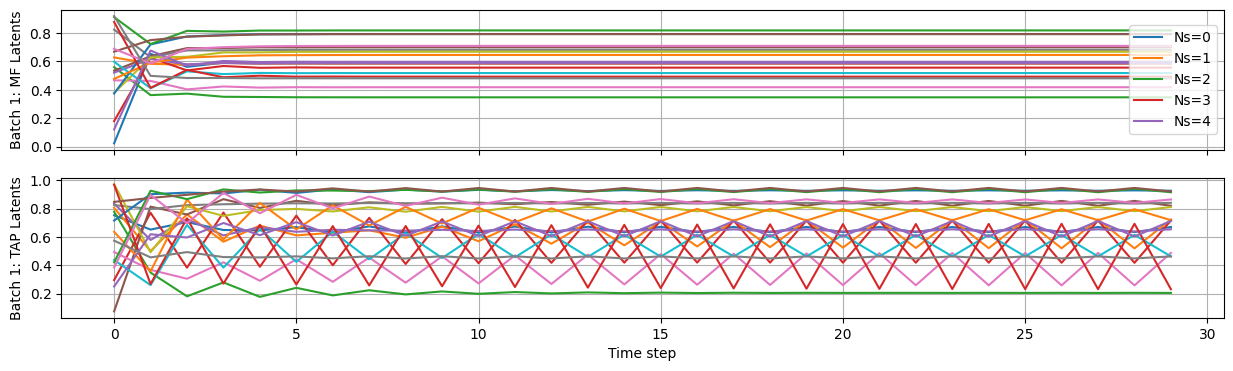

In [49]:
# Plot MF and TAP latent updates
B_to_plot = 2 
B_total, Ns, T = x_train_TAP.shape

fig, axs = plt.subplots(B_to_plot, 1, figsize=(15, 2*B_to_plot), sharex=True)

# Plot MF latents
for n in range(Ns):
    axs[0].plot(x_train_MF[0, n, :], label=f'Ns={n}' if n<5 else None)
axs[0].set_ylabel(f'Batch 1: MF Latents')
axs[0].grid(True)

# Plot TAP latents
for n in range(Ns):
    axs[1].plot(x_train_TAP[0, n, :], label=f'Ns={n}')
axs[1].set_ylabel(f'Batch 1: TAP Latents')
axs[1].grid(True)

axs[-1].set_xlabel('Time step')
axs[0].legend(loc='right')  # show legend only on first plot
plt.show()


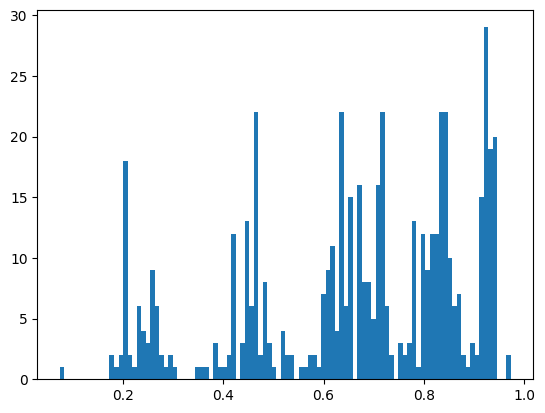

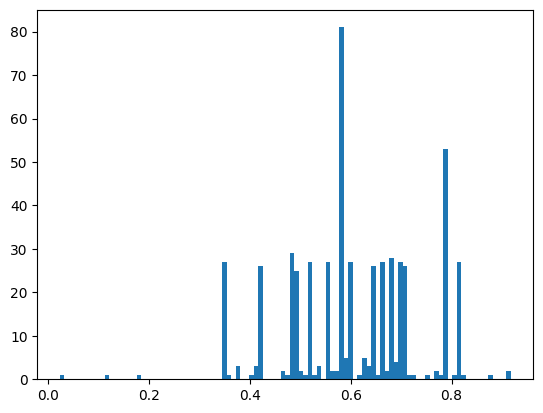

In [51]:
# Plot distribution over latents
plt.hist(x_train_TAP.flatten(),100)
plt.show()

plt.hist(x_train_MF.flatten(),100)
plt.show()


## Temporal Coarse-Grain

### Here we use a jumping window whose stride is equal to the window size, so it does not act as a loss-pass filter

In [ ]:
# Average y and x
# reshape so the last dimension becomes (num_groups, window_avg)
window_avg = 5
x_arr_grouped = x_train.reshape(B_train, Ns, T // window_avg, window_avg)
# average over each group
x_arr_avg = x_arr_grouped.mean(axis=-1)

# # Reshape y_train
# # first, trim y_train so its time dimension is divisible by window_avg
num_obs_reshaped = y_train.shape[2] // window_avg
y_train_trimmed = y_train[:, : , -num_obs_reshaped * window_avg:]
# reshape so the last dimension becomes (num_groups, window_avg)
y_arr_grouped = y_train_trimmed.reshape(B_train, Ny, num_obs_reshaped, window_avg)
# average over each group
y_arr_avg = y_arr_grouped.mean(axis=-1)
G_coarse_inferred = tap.infer_exact_G(y_arr_avg, x_arr_avg, params,theta)
print("hi")

hi


In [15]:
import numpy as np

def divisors(n):
    """Return all positive divisors of n sorted."""
    return sorted([d for d in range(1, n+1) if n % d == 0])

T = x_train.shape[2]
window_list = divisors(T)

G_results = {}   # dictionary: key = window_avg, value = G_coarse_inferred

for window_avg in window_list[:-1]:
    # --- X ---
    x_arr_grouped = x_train.reshape(B_train, Ns, T // window_avg, window_avg)
    x_arr_avg = x_arr_grouped.mean(axis=-1)

    # --- Y ---
    num_obs_reshaped = y_train.shape[2] // window_avg

    y_train_trimmed = y_train[:, :, -num_obs_reshaped * window_avg:]
    y_arr_grouped = y_train_trimmed.reshape(B_train, Ny, num_obs_reshaped, window_avg)
    y_arr_avg = y_arr_grouped.mean(axis=-1)

    # --- Inference ---
    G_coarse_inferred = tap.infer_exact_G(y_arr_avg, x_arr_avg, params, theta)

    # --- Save result ---
    G_results[window_avg] = G_coarse_inferred

# Optional: print what you collected
for w, Gval in G_results.items():
    print(f"window_avg = {w}: G = {Gval}")


window_avg = 1: G = [-4.72718903e-15  2.00000000e+00 -1.86810350e-14  1.29544013e-14
  1.19020725e-14 -5.37719052e-14 -1.68094130e-14 -3.29418587e-14
  8.41668955e-14  7.07699516e-15  4.00000000e+00 -4.00000000e+00
 -6.77233874e-14 -8.00000000e+00  8.00000000e+00  8.37630435e-14
 -7.90034593e-13  9.01301251e-13]
window_avg = 2: G = [ -157.38482886   679.76154037  -521.85994342   879.43189231
 -3499.26804332  2458.94249915 -1109.751585    4179.37225753
 -2709.86795451    32.82777946  -645.76426695  1030.10873561
  -160.88959796  3623.52891107 -5226.50531098   -41.98404981
 -3532.66524571  5237.75916755]
window_avg = 3: G = [  -9.09233398   38.37638626  -22.93169989   49.06402535 -170.94467727
   97.54115934  -57.60109424  184.4403093   -97.73408249   -3.34686524
  -20.91131969   57.84254845   30.98325832   47.61378258 -194.37266088
  -43.17994122  -21.41737537  163.2603327 ]
window_avg = 5: G = [  -56.30974907   232.53482126  -206.57198795   336.29758579
 -1310.61192461  1153.45041796  

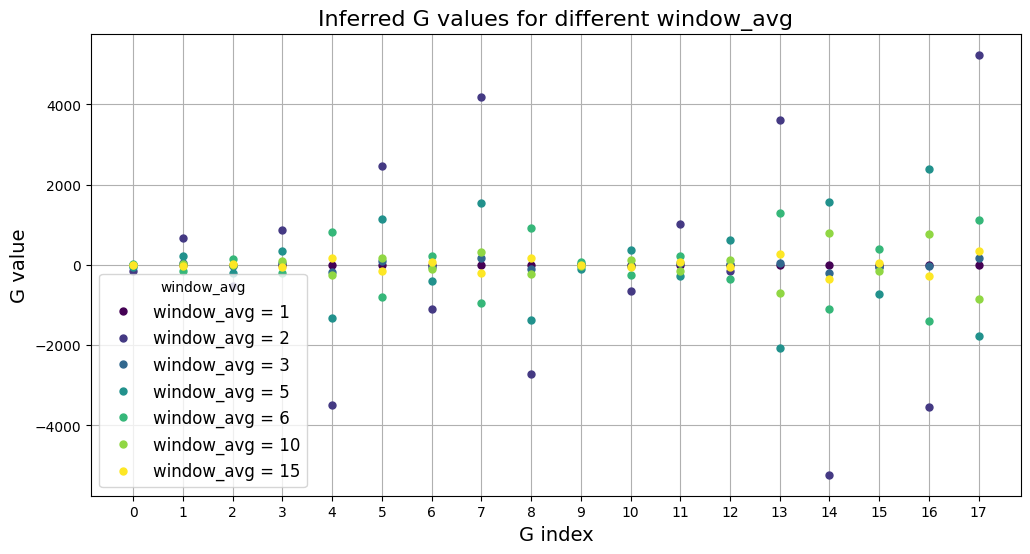

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Get sorted window sizes
window_list = sorted(G_results.keys())

# Assume all G vectors have same length
G_length = len(next(iter(G_results.values())))
x = np.arange(G_length)

# Colormap
cmap = plt.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, len(window_list)))

plt.figure(figsize=(12, 6))

# Plot each G vector
for color, w in zip(colors, window_list):
    G_vec = G_results[w]
    plt.plot(x, G_vec, '.', color=color, markersize=10, label=f"window_avg = {w}")

plt.xlabel("G index", fontsize=14)
plt.ylabel("G value", fontsize=14)
plt.title("Inferred G values for different window_avg", fontsize=16)
plt.grid(True)
plt.legend(title="window_avg", fontsize=12)
plt.xticks(x)   # show each G index on the x-axis

plt.show()


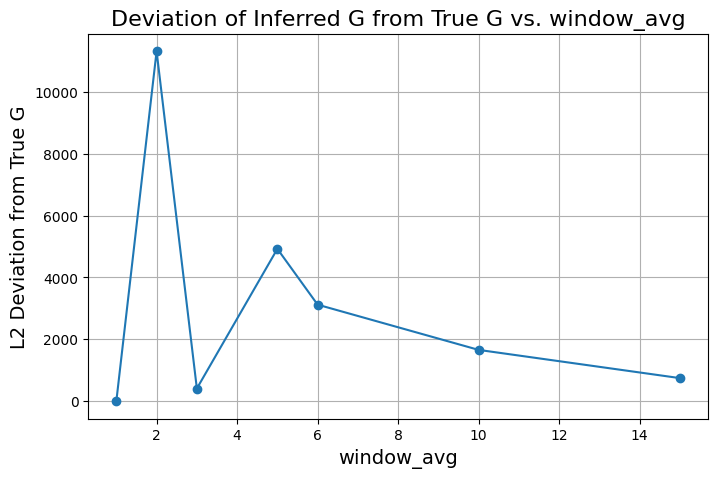

In [18]:
# Plot window_avg by deviations from true G
true_G = G
deviations = []
window_sizes = []
for w, Gval in G_results.items():
    deviation = np.linalg.norm(Gval - true_G, ord=2)
    deviations.append(deviation)
    window_sizes.append(w)

plt.figure(figsize=(8,5))
plt.plot(window_sizes, deviations, 'o-')
plt.xlabel("window_avg", fontsize=14)
plt.ylabel("L2 Deviation from True G", fontsize=14)
plt.title("Deviation of Inferred G from True G vs. window_avg", fontsize=16)
plt.grid(True)
plt.show()

### Here we use a jumping window with stride=1, so it acts as a loss-pass filter

In [28]:
# Average y and x
kernel = 5
stride = 30

def convolve(x_train, kernel, stride):
    B, Ns, T = x_train.shape
    start = 0
    end = kernel
    while start < T:
        if end > T:
            end = T
        x_segment = x_train[:, :, start:end]
        x_avg = x_segment.mean(axis=-1, keepdims=True)
        if start == 0:
            x_smooth = x_avg
        else:
            x_smooth = np.concatenate((x_smooth, x_avg), axis=-1)
        start += stride
        end += stride
    return x_smooth
    
 

# Smooth x and y
x_smooth = convolve(x_train, kernel=30, stride=29)
print(x_smooth.shape)   # (B, Ns, T)

# # Reshape y_train
y_smooth = convolve(y_train, kernel=5, stride=1)
print(y_smooth.shape)   # (B, Ny, T)

G_coarse_inferred = tap.infer_exact_G(y_smooth, x_smooth, params,theta)
print("hi")

(1, 18, 2)
(1, 18, 29)
hi


In [37]:
import numpy as np


T = x_train.shape[2]
kernel_list = range(1,T+1)  # Example kernel sizes from 1 to 10
stride_list = range(1,T)

G_results = {}   # dictionary: key = window_avg, value = G_coarse_inferred

for kernel in kernel_list:
    for stride in stride_list:
        # --- X ---
        x_smooth = convolve(x_train, kernel=kernel, stride=stride)

        # --- Y ---
        y_smooth = convolve(y_train, kernel=kernel, stride=stride)

        # --- Inference ---
        G_coarse_inferred = tap.infer_exact_G(y_smooth, x_smooth, params, theta)
        # --- Save result ---
        G_results[(kernel, stride)] = G_coarse_inferred
# Optional: print what you collected
for (kernel,stride), Gval in G_results.items():
    print(f"Kernel = {kernel}, Stride = {stride}: G = {Gval}")

Kernel = 1, Stride = 1: G = [-3.78163439e+00  1.15160538e+02 -1.29250660e+02  7.86706881e+01
 -8.45308685e+02  9.05971255e+02 -1.31957745e+02  1.10870555e+03
 -1.16840253e+03  2.55503705e+02 -1.10388508e+03  1.09540700e+03
 -9.92999692e+02  4.42139818e+03 -4.49773162e+03  8.73418519e+02
 -4.09689031e+03  4.31519376e+03]
Kernel = 1, Stride = 2: G = [  -36.16133685   174.6748509   -197.63964667   177.90420313
  -910.60856438  1047.19360055  -188.67935493  1008.40674033
 -1160.90105019   112.82139724  -475.106484     435.56789115
  -515.19963828  2252.98643294 -2122.43224238   581.71870298
 -2704.28284543  2680.44408554]
Kernel = 1, Stride = 3: G = [  -10.9659701    170.49920972  -189.93354689   130.60718952
 -1199.53260178  1281.55205836  -206.7860267   1577.41915431
 -1654.85403155   360.57038228 -1564.30503892  1544.38511092
 -1429.52886269  6377.38370754 -6430.15821973  1283.53679959
 -6037.13124955  6299.8578375 ]
Kernel = 1, Stride = 4: G = [  -47.00211054   180.40895205  -208.22578

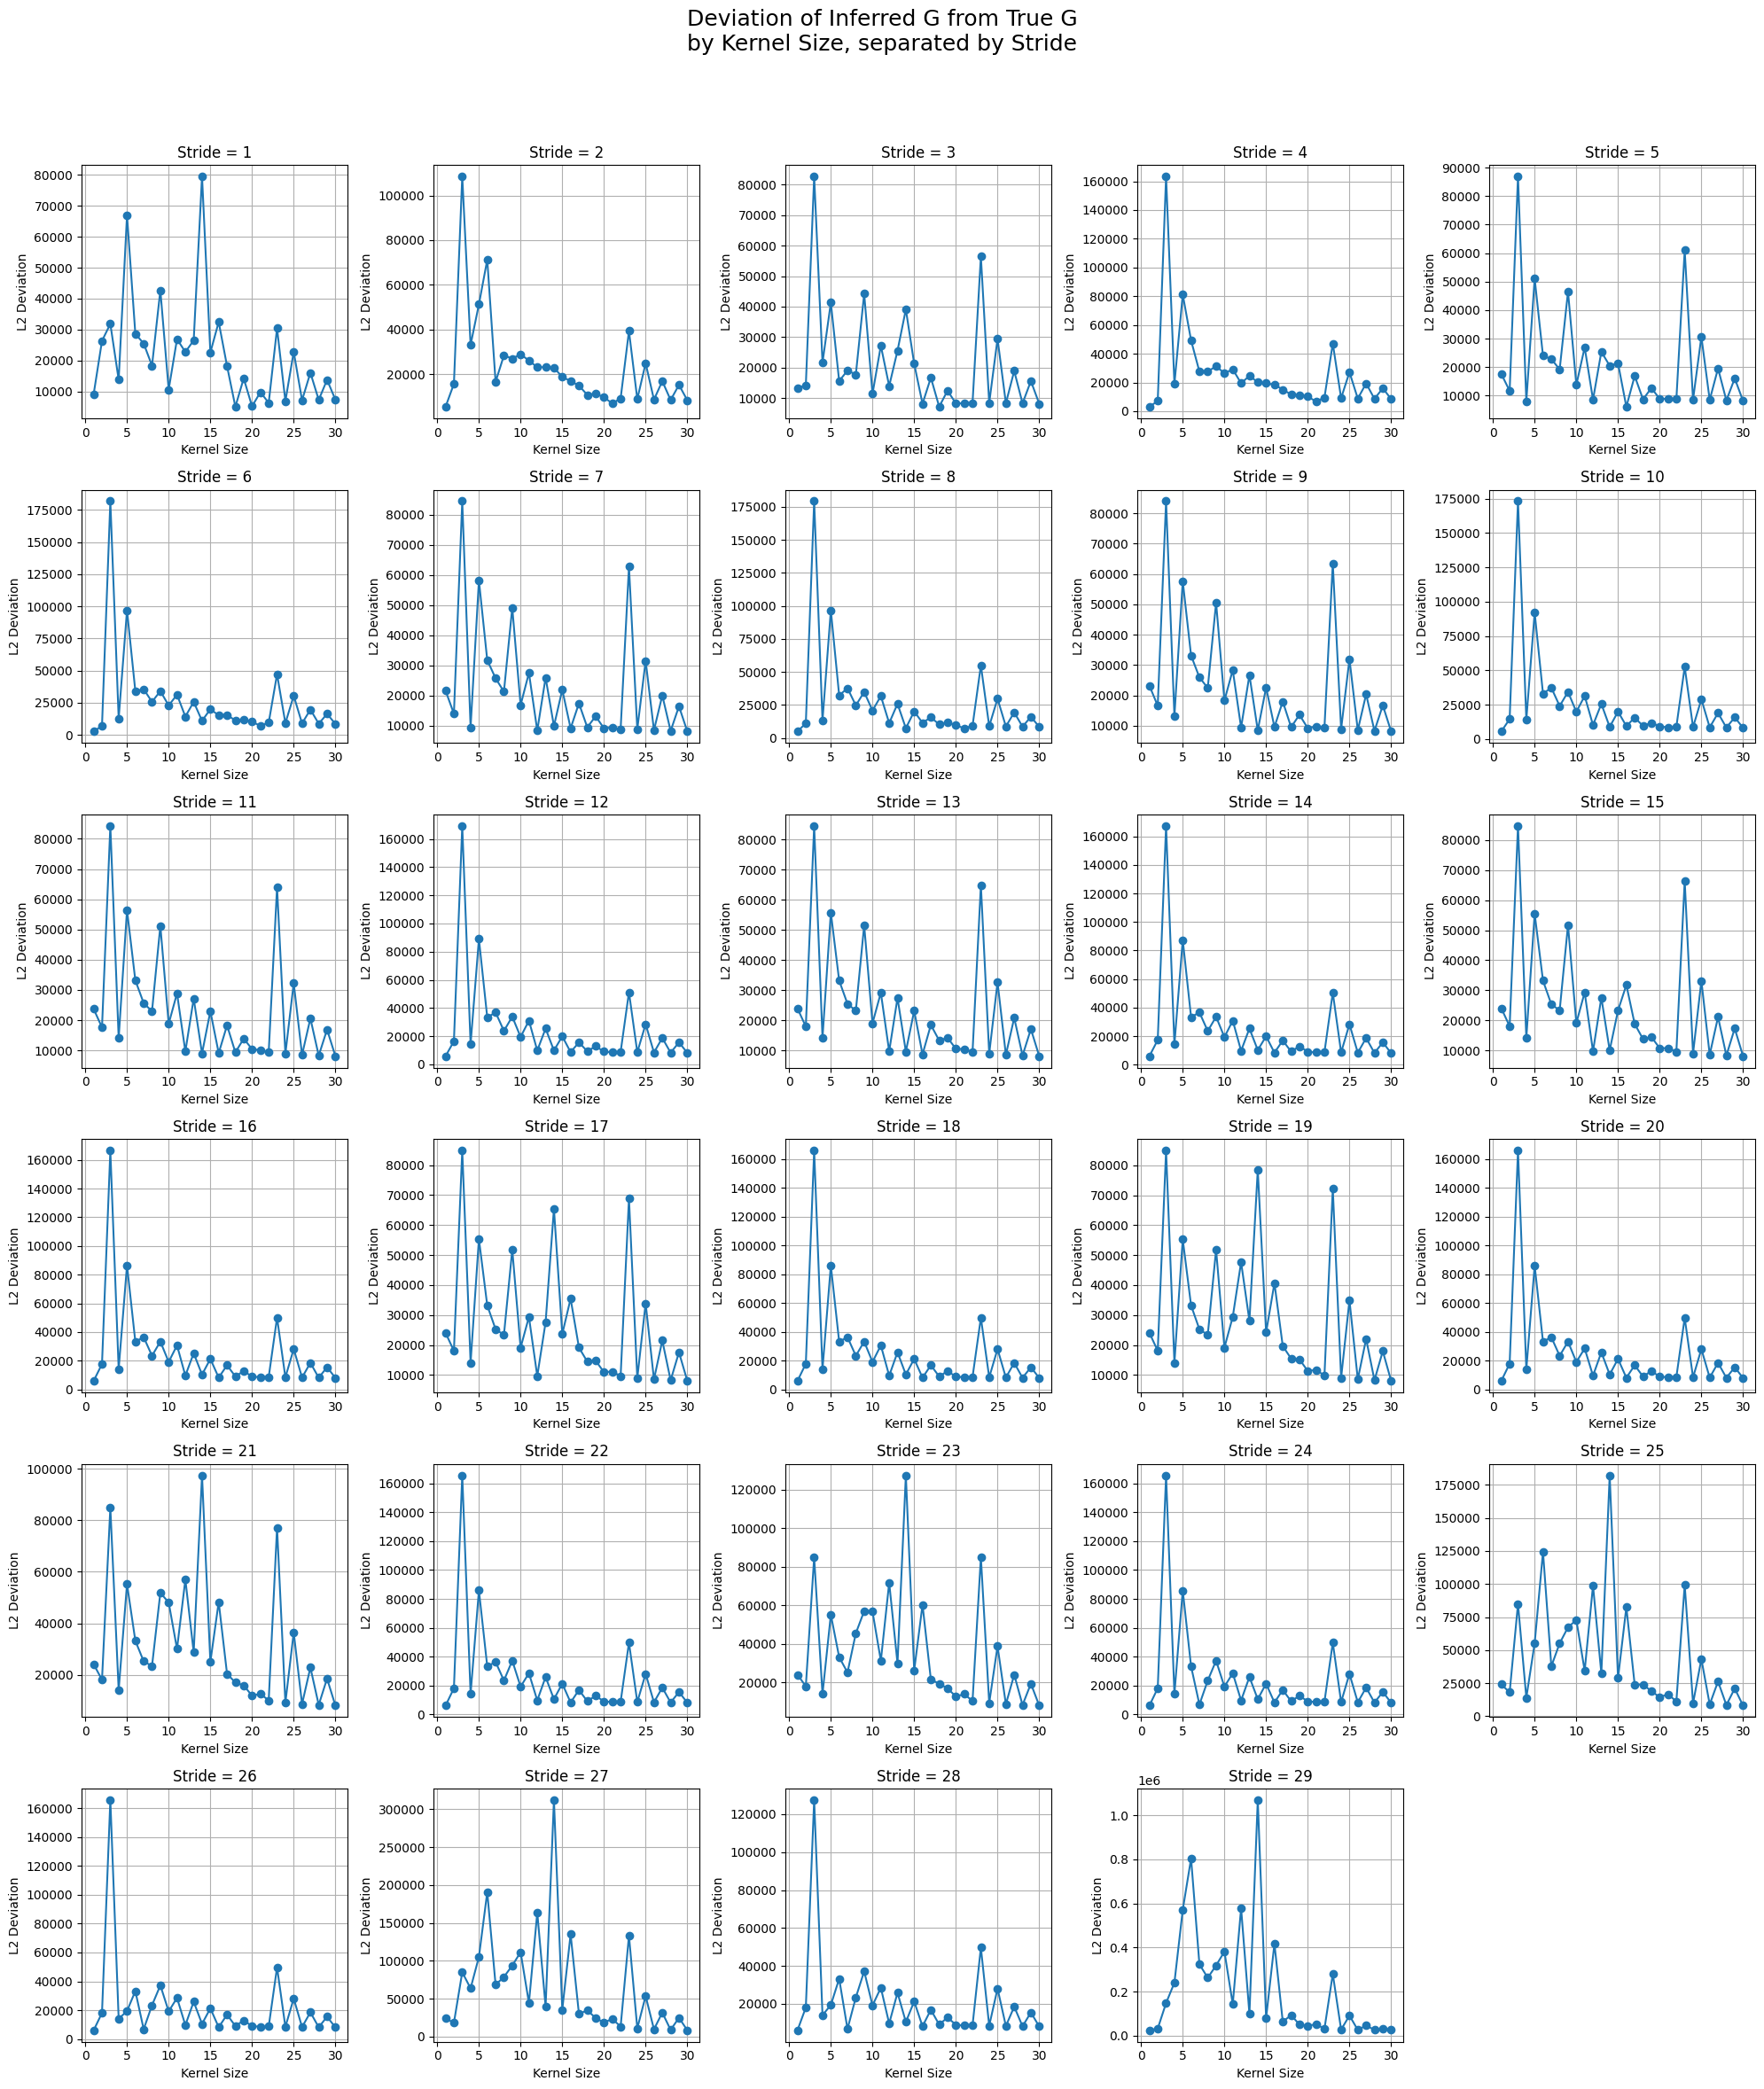

In [38]:
import matplotlib.pyplot as plt
import numpy as np

true_G = G

# --- Collect unique kernel sizes and strides ---
kernels = sorted(set(k for (k, s) in G_results.keys()))
strides = sorted(set(s for (k, s) in G_results.keys()))

# --- Subplot layout: 5 columns, as many rows as needed ---
n_strides = len(strides)
n_cols = 5
n_rows = int(np.ceil(n_strides / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), squeeze=False)

# Flatten for easy indexing
axes = axes.flatten()

for idx, stride in enumerate(strides):
    ax = axes[idx]

    deviations = []
    window_sizes = []

    for kernel in kernels:
        key = (kernel, stride)
        if key in G_results:
            Gval = G_results[key]
            dev = np.linalg.norm(Gval - true_G, ord=2)
            deviations.append(dev)
            window_sizes.append(kernel)

    # Plot
    ax.plot(window_sizes, deviations, 'o-')
    ax.set_title(f"Stride = {stride}", fontsize=12)
    ax.set_xlabel("Kernel Size")
    ax.set_ylabel("L2 Deviation")
    ax.grid(True)

# Hide empty subplots if #strides < n_rows*n_cols
for j in range(idx + 1, n_rows*n_cols):
    axes[j].axis("off")

plt.suptitle("Deviation of Inferred G from True G\nby Kernel Size, separated by Stride", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


In [22]:
# Let's also try this when the ground truth message update function is mean-field MP
import numpy as np
# Do exact inference when data are constrained by number of nodes
# Ns = no. of latent variables, Ny = no. of inputs
Ns, Nr, Ny = 18,2,18

B_train = 1       # No. of batches; I changed from 25k to 2.5k for training batches. 
                                 # It's also kind of confusing because a single batch is Ns x T 
                                 # instead of multiple Ns x T
                                 # 
T = 30                         # No. of time steps 
kernel  = 30                     # Sliding window
stride = 5                       # how big each jump is
                                 # Here we have consistent input for the entire time period

##################
# These parameters are not used since observations are binary                                 
T_low, T_high = T, T+1           # range of time periods for which input is held constant: T and T+1 means constant for entire period
# T_low, T_high = 2, 5          # range of time periods for which input is held constant
yG_low, yG_high = np.sqrt(Ns), np.sqrt(Ns)   # These input gains give us binary observations
#yG_low, yG_high = 2, 3   # 

# process and observation noise covariance matrices
q_process, q_obs = 0, 0
Q_process, Q_obs = q_process*np.eye(Ns), q_obs*np.eye(Nr)    

# filter used for smoothing the input signals
# Carter changed from signal.hamming to signal.windows.hamming 
smoothing_filter = signal.windows.hamming(5,sym=True) 
smoothing_filter = smoothing_filter/sum(smoothing_filter)


# ground truth TAP model parameters
# lam controls how much new messages update activation
# lam = np.array([0.25])  # low pass filtering constant for the TAP dynamics
lam = np.array([1])  # low pass filtering constant for the TAP dynamics
# This should give us J*x_i*x_j
# The values of G are the coefficients G in the expression G_abc*J^a*x_i^b*x_j^c, where the index corresponds to
# the exponent of J, x_i, and x_j. I believe the order is 100, 101, 102, 110, 111... so the element at index 1 (101) means
# that a and c have exponent 1. In other words, message to Xi only depends on J*Xj
G   = np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) # message passing parameters of the TAP equation

# Connectivity matrix between state nodes
# Ns x Ns
self_coupling_on, sparsity_J, gain_J, Jtype  = 0, 0.5, 3, 'nonferr' # interaction matrix settings
J = gain_J*Create_J(Ns, sparsity_J, Jtype, self_coupling_on)
#J = array([[0,.8,-.4],[.8,0,.2],[-.4,.2,0]])  # No state dependence

# Connectivity matrix between state and observation nodes
# Ns x Ny
if Ns <= Ny:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]
# V = array([[-1,1,1],[1,-1,-1],[1,1,-1]])*3.5
V = np.zeros((Ns,Ny))  # No input dependence
# Empty embedding matrix because we don't care about neural response

embedding_arr = (Nr,Ns)
U = np.zeros(embedding_arr)
theta = np.concatenate([lam, G, JMatToVec(J), U.flatten('F'), V.flatten('F') ])

params = {'Ns':Ns,'Ny':Ny,'Nr':Nr,'Q_process':Q_process,'Q_obs':Q_obs,'nltype':'sigmoid','gain_y':25/np.sqrt(Ns),'smoothing_filter':smoothing_filter,'self_coupling_on':self_coupling_on,'sparsity_J':sparsity_J,'Jtype':Jtype  }

batches = 1
##################
# Specify sampling or message passing function
# runTAP - message passing
# runTAPSampling - sampling
TAP_func=runTAP
y_train_mf, x_train_mf, r_train_mf = tap.generate_TAPdynamics(theta, params, batches, T, T_low, T_high, yG_low, yG_high,kernel,stride,TAP_func=TAP_func)
G_inferred = tap.infer_exact_G(y_train_mf, x_train_mf, params,theta)

In [23]:
import numpy as np


T = x_train_mf.shape[2]
kernel_list = range(1,T+1)  # Example kernel sizes from 1 to 10

G_results = {}   # dictionary: key = window_avg, value = G_coarse_inferred

for kernel in kernel_list:
    # --- X ---
    x_smooth = convolve(x_train_mf, kernel=kernel, stride=1)

    # --- Y ---
    y_smooth = convolve(y_train_mf, kernel=kernel, stride=1)

    # --- Inference ---
    G_coarse_inferred = tap.infer_exact_G(y_smooth, x_smooth, params, theta)
    # --- Save result ---
    G_results[kernel] = G_coarse_inferred
# Optional: print what you collected
for kernel, Gval in G_results.items():
    print(f"Kernel = {kernel}: G = {Gval}")

Kernel = 1: G = [-1.12949584e-14  1.00000000e+00 -5.47444775e-14  4.77161911e-14
 -2.26663557e-13  2.54144150e-13 -4.47668865e-14  2.12460447e-13
 -2.31671749e-13  8.20638987e-14 -4.45834607e-13  4.65772821e-13
 -3.33964428e-13  1.77104518e-12 -1.83460424e-12  2.95343537e-13
 -1.56669533e-12  1.62095041e-12]
Kernel = 2: G = [  0.72902123  -1.96903059   2.77839488  -2.80886026  11.5152211
 -10.8247484    2.58639152 -10.68277545  10.10353798   1.28743548
  -4.34808075   3.2222602   -4.60451303  15.35083118 -11.09374202
   3.84795235 -12.52586852   8.65498476]
Kernel = 3: G = [  0.26028443  -0.10194943   1.19984699  -1.4446054    6.1135522
  -6.49443931   1.70509842  -7.25126352   7.64715026  -2.255411
   9.08609545  -8.7006656    7.80096657 -31.50401731  30.28666569
  -6.8602994   27.73893216 -26.74741937]
Kernel = 4: G = [   9.35817789  -41.54034012   46.96629856  -41.06952543  187.07848005
 -206.87755462   44.07275106 -201.18361275  222.85378659  -33.94153503
  125.31411959 -111.341092

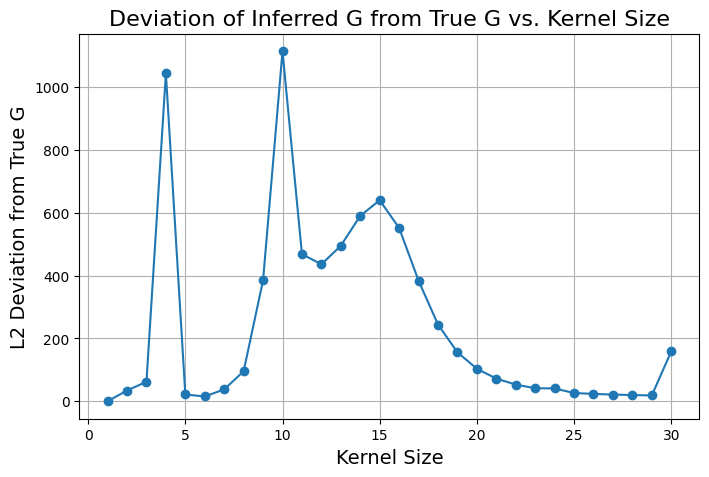

In [24]:
# Plot kernel by deviations from true G
true_G = G
deviations = []
window_sizes = []
for kernel, Gval in G_results.items():
    deviation = np.linalg.norm(Gval - true_G, ord=2)
    deviations.append(deviation)
    window_sizes.append(kernel)

plt.figure(figsize=(8,5))
plt.plot(window_sizes, deviations, 'o-')
plt.xlabel("Kernel Size", fontsize=14)
plt.ylabel("L2 Deviation from True G", fontsize=14)
plt.title("Deviation of Inferred G from True G vs. Kernel Size", fontsize=16)
plt.grid(True)
plt.show()

In [ ]:
# Pretend we're working with a rate-based code where spikes are sampled from distribution given by the marginals at each time.
